## Library Imports

In [ ]:
import os
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchmetrics.classification import MulticlassCohenKappa
from IPython.display import clear_output
import pytorch_lightning as pl
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers.wandb import WandbLogger
import wandb
from x_transformers import ContinuousTransformerWrapper, Encoder

torch.set_float32_matmul_precision('medium')

## Data Loading

### Dataset Class

In [ ]:
# Helper to safely convert strings to floats
def safe_float(x):
    try:
        return float(x)
    except:
        return np.nan

# Mapping sleep-stage labels to integers
SLEEP_STAGE_MAPPING = {
    "W": 0,    # Wake
    "N1": 1,   # non-REM stage 1
    "N2": 2,   # non-REM stage 2
    "N3": 3,   # non-REM stage 3
    "R": 4,    # REM
    "Missing": -1  # Missing label → ignore
}

# Forward‑fill NaNs in each channel
def forward_fill(x: torch.Tensor) -> torch.Tensor:
    single = False
    if x.dim() == 1:
        x = x.unsqueeze(1)
        single = True
    T, C = x.shape
    for c in range(C):
        if torch.isnan(x[0, c]):
            x[0, c] = 0.0
        for t in range(1, T):
            if torch.isnan(x[t, c]):
                x[t, c] = x[t - 1, c]
    return x.squeeze(1) if single else x

# Numeric columns for the CSV reader
numeric_columns = ['TIMESTAMP', 'BVP', 'ACC_X', 'ACC_Y', 'ACC_Z', 'TEMP', 'EDA', 'HR', 'IBI']
converters = {col: safe_float for col in numeric_columns}


class MixedFreqDataset(Dataset):
    def __init__(self,
                 subjects_list,
                 data_dir,
                 chunk_duration: float = 600,
                 chunk_stride: float = 300,
                 downsample_freq: int = 64,
                 acc_freq: int = 64,
                 feature_columns=None,
                 debug: bool = False):
        """
        Returns for each chunk:
          - non-acceleration features at `downsample_freq`
          - acceleration at `acc_freq`
          - labels at `downsample_freq`
        """
        # choose features (ACC will be computed)
        if feature_columns is None:
            self.feature_columns = ['ACC', 'TIMESTAMP', 'BVP', 'TEMP', 'HR', 'IBI']
        else:
            self.feature_columns = feature_columns

        # factors and lengths
        self.downsample     = int(64 // downsample_freq)
        self.downsample_acc = int(64 // acc_freq)
        self.chunk_length      = int(chunk_duration * downsample_freq)
        self.chunk_length_acc  = int(chunk_duration * acc_freq)
        self.stride            = int(chunk_stride * downsample_freq)
        # to align non‐acc → acc indices
        self.ratio = acc_freq / downsample_freq
        # which columns to keep *besides* ACC
        self.non_acc_idxs = [
            i for i, c in enumerate(self.feature_columns)
            if c != 'ACC'
        ]

        self.chunks = []
        for SID in subjects_list:
            path = os.path.join(data_dir, f"{SID}_whole_df.csv")
            if not os.path.exists(path):
                if debug:
                    print(f"[WARN] Missing file for {SID}, skipping")
                continue

            # 1) load
            df = pd.read_csv(path,
                             dtype={'Sleep_Stage': 'category'},
                             converters=converters,
                             low_memory=True)
            if debug:
                print(f"[INFO] {SID}: {len(df)} rows loaded")

            # 2) compute, normalize, & downsample ACC
            df['ACC'] = np.sqrt(
                df['ACC_X']**2 + df['ACC_Y']**2 + df['ACC_Z']**2
            )
            if self.downsample_acc != 1:
                df = df.iloc[::self.downsample_acc].reset_index(drop=True)
                if debug:
                    print(f"[DEBUG] {SID}: ACC ↓ to {int(64/self.downsample_acc)} Hz → {len(df)} rows")
            acc_arr = df['ACC'].values.astype(np.float32)
            acc_arr = (acc_arr - acc_arr.mean()) / acc_arr.std()



            # 3) downsample *all* channels for non‐acc view
            df = df.iloc[::self.downsample].reset_index(drop=True)
            if debug:
                print(f"[DEBUG] {SID}: non-ACC ↓ to {int(64/self.downsample)} Hz → {len(df)} rows")

            # 4) drop preparation phase, map labels
            df = df[df['Sleep_Stage'] != 'P']
            df['Sleep_Stage'] = df['Sleep_Stage'].astype(str).str.strip()
            labels_arr = (
                df['Sleep_Stage']
                  .map(SLEEP_STAGE_MAPPING)
                  .fillna(-1)
                  .astype(int)
                  .to_numpy()
            )
            # 5) normalize features
            for c in self.feature_columns:
                df[c] = (df[c] - df[c].mean()) / df[c].std() # normalizing per subject, should we do globally?
            # forward fill NaNs
            #df.ffill(inplace=True)
            #df.bfill(inplace=True)
            # 6) assemble feature matrix
            data_arr = df[self.feature_columns].values.astype(np.float32)

            # 7) pad short records
            T = data_arr.shape[0]
            if T < self.chunk_length:
                pad = self.chunk_length - T
                data_arr   = np.vstack([data_arr,
                                        np.full((pad, data_arr.shape[1]), np.nan,
                                                dtype=np.float32)])
                labels_arr = np.concatenate(
                    [labels_arr, np.full((pad,), -1, dtype=int)]
                )
                T = self.chunk_length

            # 8) slice into overlapping chunks
            for start in range(0, T - self.chunk_length + 1, self.stride):
                end       = start + self.chunk_length
                start_acc = int(start * self.ratio)
                end_acc   = start_acc + self.chunk_length_acc

                non_acc_chunk = data_arr[start:end, self.non_acc_idxs]
                acc_chunk     = acc_arr[start_acc:end_acc]
                label_chunk   = labels_arr[start:end]

                non_acc_chunk = forward_fill(torch.tensor(non_acc_chunk,dtype=torch.float32))
                acc_chunk     = forward_fill(torch.tensor(acc_chunk,dtype=torch.float32).unsqueeze(1).squeeze(1))
                label_chunk = torch.tensor(label_chunk, dtype=torch.long)

                
                self.chunks.append({
                    'non_acc': non_acc_chunk,
                    'acc':     acc_chunk,
                    'labels':  label_chunk
                })

        if debug:
            print(f"[INFO] Built {len(self.chunks)} total chunks")

    def __len__(self):
        return len(self.chunks)

    def __getitem__(self, idx):
        c = self.chunks[idx]
        #non_acc = torch.tensor(c['non_acc'], dtype=torch.float32)
        #acc     = torch.tensor(c['acc'],     dtype=torch.float32)
        #labels  = torch.tensor(c['labels'],  dtype=torch.long)
        non_acc = c['non_acc']
        acc     = c['acc']
        labels  = c['labels']
        # forward‑fill each
        #non_acc = forward_fill(non_acc)
        #acc     = forward_fill(acc.unsqueeze(1)).squeeze(1)

        return non_acc, acc, labels


### Separate subjects into train/val/test splits

In [ ]:
datadir_64Hz = '/gpfs/data/oermannlab/users/slj9342/dl4med_25/data/physionet.org/files/dreamt/2.0.0/data_64Hz/' # working with 64Hz data

dtype_dict = {
    'TIMESTAMP': np.float32,
    'BVP': np.float32,
    'ACC_X': np.float32,
    'ACC_Y': np.float32,
    'ACC_Z': np.float32,
    'TEMP': np.float32,
    'EDA': np.float32,
    'HR': np.float32,
    'IBI': np.float32,
    'Sleep_Stage': 'category',
    'Obstructive_Apnea': 'Int64', 
    'Central_Apnea': 'Int64',
    'Hypopnea': 'Int64',
    'Multiple_Events': 'Int64'
}

numeric_columns = [
    'TIMESTAMP', 'BVP', 'ACC_X', 'ACC_Y', 'ACC_Z', 'TEMP',
    'EDA', 'HR', 'IBI'
]
converters = {col: safe_float for col in numeric_columns}
'''
max_length = 0
for file in os.listdir(datadir_64Hz):
    if file.endswith('_whole_df.csv'):
        df = pd.read_csv(
            os.path.join(datadir_64Hz, file),
            dtype={'Sleep_Stage': 'category'},
            converters=converters,
            low_memory=True
        )
        max_length = max(max_length, len(df))
print(f"Max sequence length: {max_length}")
'''
max_length = 2493810

participant_info_df = pd.read_csv('/gpfs/data/oermannlab/users/slj9342/dl4med_25/data/physionet.org/files/dreamt/2.0.0/participant_info.csv')
subjects_all = participant_info_df['SID']

subjects_all_shuffled = participant_info_df['SID'].sample(frac=1, random_state=42).reset_index(drop=True)
subjects_train = subjects_all_shuffled[:int(len(subjects_all_shuffled)*0.8)]
subjects_val = subjects_all_shuffled[int(len(subjects_all_shuffled)*0.8):int(len(subjects_all_shuffled)*0.9)]
subjects_test = subjects_all_shuffled[int(len(subjects_all_shuffled)*0.9):]
print(f"number of subjects in train: {len(subjects_train)}")
print(f"number of subjects in val: {len(subjects_val)}")
print(f"number of subjects in test: {len(subjects_test)}")

# overwrite with smaller dataset for development (20% of original)
fraction = 0.3
subjects_train_small = subjects_train[:int(len(subjects_train)*fraction)]
subjects_val_small = subjects_val[:int(len(subjects_val)*fraction)]
subjects_test_small = subjects_test[:int(len(subjects_test)*fraction)]
print(f"number of subjects in small train: {len(subjects_train_small)}")
print(f"number of subjects in small val: {len(subjects_val_small)}")
print(f"number of subjects in small test: {len(subjects_test_small)}")

### Construct train, val, and test datasets

In [ ]:
non_acc_freq = 0.2
acc_freq = 32
chunk_duration = 6000 # chunk duration in seconds
chunk_stride = 1500 # chunk stride in seconds
train_dataset_mixed = MixedFreqDataset(subjects_list=subjects_train,
                                 data_dir=datadir_64Hz,
                                 chunk_duration=chunk_duration,
                                 chunk_stride=chunk_stride,
                                 downsample_freq=non_acc_freq, # downsample to 8Hz
                                 acc_freq=acc_freq,
                                 debug=False)
print(f"Total samples in train dataset: {len(train_dataset_mixed)}")
val_dataset_mixed = MixedFreqDataset(subjects_list=subjects_val,
                                 data_dir=datadir_64Hz,
                                 chunk_duration=chunk_duration,
                                 chunk_stride=chunk_stride,
                                 downsample_freq=non_acc_freq, # downsample to 8Hz
                                 acc_freq=acc_freq,
                                 debug=False)
print(f"Total samples in val dataset: {len(val_dataset_mixed)}")
test_dataset_mixed = MixedFreqDataset(subjects_list=subjects_test,
                                 data_dir=datadir_64Hz,
                                 chunk_duration=chunk_duration,
                                 chunk_stride=chunk_stride,
                                 downsample_freq=non_acc_freq, # downsample to 8Hz
                                 acc_freq=acc_freq,
                                 debug=False)
print(f"Total samples in test dataset: {len(test_dataset_mixed)}")

train_dataset_mixed_small = MixedFreqDataset(subjects_list=subjects_train_small,
                                 data_dir=datadir_64Hz,
                                 chunk_duration=chunk_duration,
                                 chunk_stride=chunk_stride,
                                 downsample_freq=non_acc_freq, # downsample to 8Hz
                                 acc_freq=acc_freq,
                                 debug=False)
print(f"Total samples in train dataset small: {len(train_dataset_mixed_small)}")
val_dataset_mixed_small = MixedFreqDataset(subjects_list=subjects_val_small,
                                 data_dir=datadir_64Hz,
                                 chunk_duration=chunk_duration,
                                 chunk_stride=chunk_stride,
                                 downsample_freq=non_acc_freq, # downsample to 8Hz
                                 acc_freq=acc_freq,
                                 debug=False)
print(f"Total samples in val dataset small: {len(val_dataset_mixed_small)}")
test_dataset_mixed_small = MixedFreqDataset(subjects_list=subjects_test_small,
                                 data_dir=datadir_64Hz,
                                 chunk_duration=chunk_duration,
                                 chunk_stride=chunk_stride,
                                 downsample_freq=non_acc_freq, # downsample to 8Hz
                                 acc_freq=acc_freq,
                                 debug=False)
print(f"Total samples in test dataset small: {len(test_dataset_mixed_small)}")
torch.save(train_dataset_mixed, 'datasets/train_dataset_mixed.pt')
torch.save(val_dataset_mixed, 'datasets/val_dataset_mixed.pt')
torch.save(test_dataset_mixed, 'datasets/test_dataset_mixed.pt')
torch.save(train_dataset_mixed_small, 'datasets/train_dataset_mixed_small.pt')
torch.save(val_dataset_mixed_small, 'datasets/val_dataset_mixed_small.pt')
torch.save(test_dataset_mixed_small, 'datasets/test_dataset_mixed_small.pt')

In [ ]:
torch.save(train_dataset_mixed.chunks, 'datasets/train_dataset_mixed_chunks.pt')
torch.save(val_dataset_mixed.chunks, 'datasets/val_dataset_mixed_chunks.pt')
torch.save(test_dataset_mixed.chunks, 'datasets/test_dataset_mixed_chunks.pt')
torch.save(train_dataset_mixed_small.chunks, 'datasets/train_dataset_mixed_small_chunks.pt')
torch.save(val_dataset_mixed_small.chunks, 'datasets/val_dataset_mixed_small_chunks.pt')
torch.save(test_dataset_mixed_small.chunks, 'datasets/test_dataset_mixed_small_chunks.pt')

In [ ]:
train_dataset_mixed = MixedFreqDataset(subjects_list=[],data_dir=None, debug=False)
val_dataset_mixed = MixedFreqDataset(subjects_list=[],data_dir=None, debug=False)
test_dataset_mixed = MixedFreqDataset(subjects_list=[],data_dir=None, debug=False)
train_dataset_mixed.chunks = torch.load('datasets/train_dataset_mixed_chunks.pt')
val_dataset_mixed.chunks = torch.load('datasets/val_dataset_mixed_chunks.pt')
test_dataset_mixed.chunks = torch.load('datasets/test_dataset_mixed_chunks.pt')

## Model Definition

In [ ]:
class ACCFeatureExtractorCNN(nn.Module):
    def __init__(self, output_channels=16, dropout=0.1):
        super(ACCFeatureExtractorCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=output_channels, kernel_size=512, stride=2)
        self.conv2 = nn.Conv1d(in_channels=output_channels, out_channels=output_channels, kernel_size=256, stride=2)
        self.conv3 = nn.Conv1d(in_channels=output_channels, out_channels=output_channels, kernel_size=256, stride=2)
        self.conv4 = nn.Conv1d(in_channels=output_channels, out_channels=output_channels, kernel_size=32, stride=2)

        self.bn1 = nn.BatchNorm1d(output_channels)
        self.bn2 = nn.BatchNorm1d(output_channels)
        self.bn3 = nn.BatchNorm1d(output_channels)
        self.bn4 = nn.BatchNorm1d(output_channels)

        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        assert not torch.isnan(x).any(), "NaN detected in CNN input"
        # Expect x of shape (batch, epoch_samples, channels)
        x = x.permute(0, 2, 1)  # (batch, channels (1), epoch_samples)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.dropout(x)
        x = self.pool1(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.dropout(x)
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.dropout(x)
        x = self.pool2(x)
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.dropout(x)

        return x


class ACCAwareSleepStager(pl.LightningModule):
    def __init__(self, non_acc_dim: int,
                 cnn_output_channels: int = 16,
                 lstm_hidden_size:   int = 64,
                 lstm_layers:        int = 2,
                 num_sleep_stages:   int = 5,
                 lr:                  float = 1e-3,
                 dropout:           float = 0.1,
                 label_smoothing:   float = 0.1,
                 weight_tensor:      torch.Tensor = None,
                 debug:            bool = False,):
        super().__init__()
        self.save_hyperparameters()

        self.acc_cnn = ACCFeatureExtractorCNN(cnn_output_channels, dropout=dropout)

        self.lstm_input_size = cnn_output_channels + non_acc_dim
        self.lstm = nn.LSTM(input_size=self.lstm_input_size,
                            hidden_size=lstm_hidden_size,
                            num_layers=lstm_layers,
                            dropout=dropout,
                            bidirectional=True,
                            batch_first=False)
        self.classifier = nn.Linear(lstm_hidden_size*2, num_sleep_stages)

        
        self.lr = lr
        self.debug = debug
        self.kappa = MulticlassCohenKappa(num_classes=num_sleep_stages)

        if weight_tensor is not None:
            assert weight_tensor.shape[0] == num_sleep_stages, \
                f"Weight tensor shape {weight_tensor.shape[0]} != num_sleep_stages {num_sleep_stages}"
        self.train_criterion = nn.CrossEntropyLoss(weight=weight_tensor, ignore_index=-1, label_smoothing=label_smoothing)
        self.val_criterion = nn.CrossEntropyLoss(weight=weight_tensor, ignore_index=-1)

    
    def forward(self, non_acc, acc):
        """
        non_acc: (batch, non_acc_length, non_acc_dim)
        acc:     (batch, acc_length)  or  (batch, acc_length, 1)
        returns:
          y_hat (output_length, batch, num_sleep_stages)
        """
        # assert no nan values in input
        assert not torch.isnan(non_acc).any(), "NaN detected in non-ACC input"
        assert not torch.isnan(acc).any(), "NaN detected in ACC input"
        # ensure ACC has a channel dim
        if acc.dim() == 2:
            acc = acc.unsqueeze(-1)          # now (batch, T, 1)

        # 1) ACC → CNN → (batch, num_cnn_feats, cnn_output_length)
        acc_feats = self.acc_cnn(acc)
        if self.debug:
            print(f"[DEBUG] ACC CNN output shape: {acc_feats.shape}") # (batch, num_cnn_feats, cnn_output_length)
            print(f"[DEBUG] NON_ACC input shape: {non_acc.shape}") # (batch, non_acc_length, non_acc_dim)


        # 2) downsample whichever sequence is longer
        cnn_output_length = acc_feats.shape[2]
        non_acc_output_length = non_acc.shape[1]
        if cnn_output_length > non_acc_output_length:
            if self.debug:
                print(f"[DEBUG] Downsampling ACC features from {cnn_output_length} to {non_acc_output_length}")
            acc_feats = F.interpolate(
                acc_feats,
                size=non_acc_output_length)
        else:
            if self.debug:
                print(f"[DEBUG] Downsampling non-ACC features from {non_acc_output_length} to {cnn_output_length}")
            non_acc = F.interpolate(
                non_acc.permute(0,2,1),  # (batch, non_acc_dim, non_acc_length) (for interpolate function syntax)
                size=cnn_output_length)
            non_acc = non_acc.permute(0,2,1)  # (batch, non_acc_length, non_acc_dim) (switching back)

        if self.debug:
            print(f"[DEBUG] ACC features shape: {acc_feats.shape}")
            print(f"[DEBUG] non-ACC features shape: {non_acc.shape}")

        # 3) build LSTM input: (T', batch, feature_dim)
        a = acc_feats.permute(2, 0, 1)        # (lstm_seq_len, batch, cnn_output_features)
        b = non_acc.permute(1, 0, 2)       # (lstm_seq_len, batch, non_acc_dim)
        lstm_in = torch.cat([a, b], dim=2)    # (lstm_seq_len, batch, C_cnn + D_nonacc)
        # without batch_first = true, LSTM input shape is (seq_len, batch_size, features)

        if self.debug:
            print(f"[DEBUG] LSTM input shape: {lstm_in.shape}")

        # 4) LSTM + classifier
        lstm_out, _ = self.lstm(lstm_in)      # (lstm_seq_len, batch, 2*lstm_hidden_size)
        if self.debug:
            print(f"[DEBUG] LSTM output shape: {lstm_out.shape}")
        y_hat = self.classifier(lstm_out)     # (lstm_seq_len, batch, num_sleep_stages)
        if self.debug:
            print(f"[DEBUG] Classifier output shape: {y_hat.shape}")
        return y_hat

    def training_step(self, batch, batch_idx):
        non_acc, acc, labels = batch
        '''
        non_acc: (batch, non_acc_length, non_acc_dim)
        acc:     (batch, acc_length)  or  (batch, acc_length, 1)
        labels:  (batch, non_acc_length)
        '''
        y_hat = self(non_acc, acc)            # (lstm_seq_len, batch, num_sleep_stages)
        y_hat = y_hat.permute(1, 0, 2)        # (batch, lstm_seq_len, num_sleep_stages)


        # flatten
        batch_size, output_length, num_sleep_stages = y_hat.shape
        y_hat_flat = y_hat.reshape(batch_size * output_length, num_sleep_stages)
        labels_flat  = labels.reshape(batch_size * output_length)
        
        # calculate loss
        loss = self.train_criterion(y_hat_flat, labels_flat)

        self.log('train_loss', loss, prog_bar=True, on_step=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        non_acc, acc, labels = batch
        '''
        non_acc: (batch, non_acc_length, non_acc_dim)
        acc:     (batch, acc_length)  or  (batch, acc_length, 1)
        labels:  (batch, non_acc_length)
        '''
        y_hat = self(non_acc, acc)            # (lstm_seq_len, batch, num_sleep_stages)
        y_hat = y_hat.permute(1, 0, 2)        # (batch, lstm_seq_len, num_sleep_stages)

        # flatten
        batch_size, output_length, num_sleep_stages = y_hat.shape
        y_hat_flat = y_hat.reshape(batch_size * output_length, num_sleep_stages)
        labels_flat  = labels.reshape(batch_size * output_length)
        
        # calculate loss
        loss = self.val_criterion(y_hat_flat, labels_flat)

        # calculate accuracy
        predictions = torch.argmax(y_hat_flat, dim=1)
        mask = labels_flat != -1
        masked_preds = predictions[mask]
        masked_labels = labels_flat[mask]
        if masked_labels.numel() > 0:
            acc = (masked_preds == masked_labels).float().mean().item()
        else:
            acc = 0.0

        # calculate cohen's kappa
        mask = labels_flat != -1
        y_valid = labels_flat[mask]
        preds_valid = predictions[mask]
        if y_valid.numel() > 0:
            self.kappa.update(preds_valid, y_valid)

        # log metrics
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc",  acc,  prog_bar=True)

        return {"val_loss": loss, "val_acc": acc}
    
    def on_validation_epoch_end(self):
        k = self.kappa.compute()
        self.log("val_cohen_kappa", torch.nan_to_num(k,0.0), prog_bar=True)
        self.kappa.reset()


    def configure_optimizers(self):
        return torch.optim.AdamW(
            self.parameters(),
            lr=self.lr,
            weight_decay=1e-5
        )


### Model Demo (shape compatibility)

In [ ]:
#train_dataset_mixed = torch.load('datasets/train_dataset_mixed.pt')

temp_non_acc, temp_acc, temp_labels = train_dataset_mixed[0]
print(f"Non-acc shape: {temp_non_acc.shape}")
print(f"ACC shape: {temp_acc.shape}")
print(f"Labels shape: {temp_labels.shape}")

CNN_model = ACCFeatureExtractorCNN(output_channels=16)
CNN_model.eval()
cnn_output = CNN_model(temp_acc.unsqueeze(0).unsqueeze(2)) # add batch and channel dimensions
print(f"Output shape: {cnn_output.shape} (batch_size, cnn_output_channels, epoch_samples)")
print(f"CNN downsampling factor: {temp_acc.shape[0] / cnn_output.shape[2]}")

model = ACCAwareSleepStager(
    non_acc_dim=temp_non_acc.shape[1],
    cnn_output_channels=16,
    lstm_hidden_size=64,
    lstm_layers=2,
    num_sleep_stages=5,
    lr=1e-3,
    debug=True
)
out = model(temp_non_acc.unsqueeze(0), temp_acc.unsqueeze(0).unsqueeze(2))

## Get Class Weights

In [ ]:
# get class weights for weighted loss

all_labels = []
for batch in DataLoader(train_dataset_mixed, batch_size=1):
    labels = batch[2].numpy()
    all_labels.extend(labels.flatten())
all_labels = np.array(all_labels)
valid_labels = all_labels[all_labels != -1]
classes = np.arange(5)
class_counts = Counter(valid_labels)
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=valid_labels
)
print(f"Class counts: {class_counts}")
print(f"Class weights: {class_weights}")

## Hyperparameter Optimization

In [ ]:
import optuna

def objective(trial):
    # Sample hyperparameters
    cnn_output_channels = trial.suggest_categorical("cnn_output_channels", [8, 16, 32, 64, 128])
    lstm_hidden_size = trial.suggest_categorical("lstm_hidden_size", [32, 64, 128, 256])
    num_layers = trial.suggest_categorical("num_layers",[2,4,6])
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    label_smoothing = trial.suggest_float("label_smoothing", 0.0, 0.3)
    
    wandb_logger = WandbLogger(name=f"nf_{cnn_output_channels}hs_{lstm_hidden_size}lr_{learning_rate}", project="acc_aware_model")
    checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='checkpoints/',
    filename='best-checkpoint',
    save_top_k=1,
    mode='min'
    )
    early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=8,
    verbose=True,
    mode='min'
    )
    trainer = pl.Trainer(
    max_epochs=15,
    devices=1,
    accelerator='gpu',
    logger=wandb_logger,
    callbacks=[checkpoint_callback, early_stop_callback],
    log_every_n_steps=1,
    precision="16-mixed",
    )
    model = ACCAwareSleepStager(
    non_acc_dim=5,
    cnn_output_channels=cnn_output_channels,
    lstm_hidden_size=lstm_hidden_size,
    lstm_layers=num_layers,
    num_sleep_stages=5,
    lr=learning_rate,
    dropout=dropout,
    label_smoothing=label_smoothing,
    weight_tensor=torch.tensor(class_weights, dtype=torch.float32),
    )

    train_loader = DataLoader(train_dataset_mixed, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset_mixed, batch_size=32, shuffle=False)
    trainer.fit(model, train_loader, val_loader)
    wandb.finish()
    clear_output()

    # 3) grab the best val_loss *and* the path to that checkpoint
    best_val_loss  = checkpoint_callback.best_model_score.item()
    best_ckpt_path = checkpoint_callback.best_model_path

    # 4) record the checkpoint path in this trial’s metadata
    trial.set_user_attr("best_ckpt", best_ckpt_path)

    return best_val_loss

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=500)
best_trial = study.best_trial
print("Best trial:")
print(f"  Value: {best_trial.value}")
print("  Params:")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

best_cnn_output_channels = best_trial.params["cnn_output_channels"]
best_lstm_hidden_size = best_trial.params["lstm_hidden_size"]
best_num_layers = best_trial.params["num_layers"]
best_dropout = best_trial.params["dropout"]
best_label_smoothing = best_trial.params["label_smoothing"]
best_learning_rate = best_trial.params["learning_rate"]


## Model Training

In [20]:
#best_cnn_output_channels = 64
#best_lstm_hidden_size = 128
#best_num_layers = 4
#best_dropout = 0.1
#best_label_smoothing = 0.1
#best_learning_rate = 0.00127

# Train the acc aware model
wandb_logger = WandbLogger(project="mixed_freq_cnn_lstm")
kappa_checkpoint = ModelCheckpoint(
    monitor='val_cohen_kappa',
    dirpath='checkpoints/mixed_freq_cnn_lstm/kappa',
    filename='best-checkpoint',
    save_top_k=1,
    mode='max'
)
loss_checkpoint = ModelCheckpoint(
    monitor='val_loss',
    dirpath='checkpoints/mixed_freq_cnn_lstm/loss',
    filename='best-checkpoint',
    save_top_k=1,
    mode='min'
)
early_stop_callback = EarlyStopping(
    monitor='val_cohen_kappa',
    patience=10,
    verbose=True,
    mode='max'
)
trainer = pl.Trainer(
    max_epochs=100,
    devices=1,
    accelerator='gpu',
    logger=wandb_logger,
    log_every_n_steps=1,
    precision="16-mixed",
    #callbacks=[checkpoint_callback, early_stop_callback]
    callbacks=[kappa_checkpoint,loss_checkpoint,early_stop_callback]
)
model = ACCAwareSleepStager( # cnn_output 32, lstm_hidden 128, lr 1e-4 did ok
    non_acc_dim=5,
    cnn_output_channels=best_cnn_output_channels,
    lstm_hidden_size=best_lstm_hidden_size,
    lstm_layers=2,
    num_sleep_stages=5,
    lr=best_learning_rate,
    weight_tensor=torch.tensor(class_weights, dtype=torch.float32),
)

#train_dataset_mixed = torch.load('datasets/train_dataset_mixed.pt')
#val_dataset_mixed = torch.load('datasets/val_dataset_mixed.pt')
train_loader = DataLoader(train_dataset_mixed, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset_mixed, batch_size=16, shuffle=False)
trainer.fit(model, train_loader, val_loader)
wandb.finish()


/gpfs/data/oermannlab/users/slj9342/.conda/envs/dl4med_25/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /gpfs/data/oermannlab/users/slj9342/.conda/envs/dl4m ...
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/gpfs/data/oermannlab/users/slj9342/.conda/envs/dl4med_25/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /gpfs/data/oermannlab/users/slj9342/dl4med_final_project/checkpoints/mixed_freq_cnn_lstm/kappa exists and is not empty.
/gpfs/data/oermannlab/users/slj9342/.conda/envs/dl4med_25/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /gpfs/data/oermannlab/users/slj9342/dl4med_final_project/checkpoints/mixed_freq_cnn_lstm/loss exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                   | Params | Mode 
-------------------------------------------------------------------
0 | acc_cnn         | ACCFeatureExtractorCNN | 2.3 M  | train
1 | lstm            | LSTM                   | 599 K  | train
2 | classifier      | Linear                 | 1.3 K  | train
3 | kappa           | MulticlassCohenKappa   | 0      | train
4 | train_criterio

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_cohen_kappa improved. New best score: 0.065


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_cohen_kappa improved by 0.067 >= min_delta = 0.0. New best score: 0.132


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_cohen_kappa improved by 0.037 >= min_delta = 0.0. New best score: 0.169


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_cohen_kappa improved by 0.025 >= min_delta = 0.0. New best score: 0.194


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_cohen_kappa improved by 0.018 >= min_delta = 0.0. New best score: 0.211


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_cohen_kappa improved by 0.012 >= min_delta = 0.0. New best score: 0.224


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_cohen_kappa did not improve in the last 10 records. Best score: 0.224. Signaling Trainer to stop.


epoch,▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇███████
train_loss_epoch,███▇▇▇▆▆▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
train_loss_step,▆█▇▇▆▆▅▅▄█▇▇▅▃▆▃▄▅▅▂▄▃▃▃▄▂▄▃▄▁▁▃▂▃▃▃▂▂▂▂
trainer/global_step,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇███
val_acc,▁▄▅▆▄▆▅▆▆▅▆▆▇▇▇▇▇██▇██▇██
val_cohen_kappa,▁▄▆▇▆▇▆▇▆▆▆▆▇▆█▇▆▇█▇▇▇▇▇▇
val_loss,▄▃▃▁▁▁▁▂▃▃▄▅▄▅▅▅▆▆▆▇▆▇▇▇█
epoch,24
train_loss_epoch,0.92132
train_loss_step,0.97864
trainer/global_step,9999


## Test


best_by_loss:
  Accuracy:          0.3518
  Cohen’s kappa:     0.1912
  Macro AUROC (OVO): 0.6714


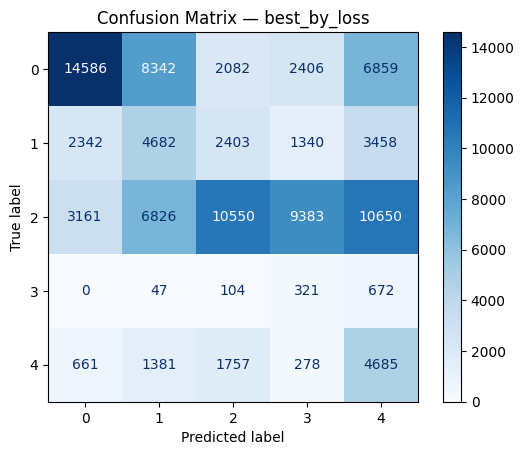


best_by_kappa:
  Accuracy:          0.4217
  Cohen’s kappa:     0.2189
  Macro AUROC (OVO): 0.6670


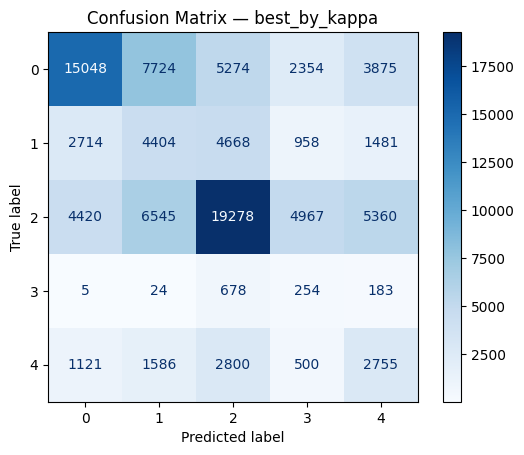

In [23]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, cohen_kappa_score, roc_auc_score, confusion_matrix

def evaluate_model(model, dataloader):
    # figure out where the model lives (cpu or cuda)
    device = next(model.parameters()).device
    model.eval()

    all_labels = []
    all_preds  = []
    all_probs  = []

    with torch.no_grad():
        for non_acc, acc, labels in dataloader:
            # move inputs to model's device
            non_acc = non_acc.to(device)
            acc     = acc.to(device)

            # forward
            y_hat = model(non_acc, acc)           # (seq_len, batch, C)
            y_hat = y_hat.permute(1, 0, 2)        # (batch, seq_len, C)
            B, T, C = y_hat.shape

            # flatten
            logits = y_hat.reshape(B*T, C)
            probs  = torch.softmax(logits, dim=1).cpu().numpy()
            preds  = probs.argmax(axis=1)
            labs   = labels.reshape(-1).numpy()

            # filter out padding (-1)
            mask = (labs != -1)
            all_labels.extend(labs[mask])
            all_preds.extend(preds[mask])
            all_probs.append(probs[mask])

    all_probs = np.concatenate(all_probs, axis=0)
    acc   = accuracy_score(all_labels, all_preds)
    kappa = cohen_kappa_score(all_labels, all_preds)
    auroc = roc_auc_score(all_labels, all_probs, multi_class='ovo', average='macro')
    cm    = confusion_matrix(all_labels, all_preds)
    return acc, kappa, auroc, cm

# Load and move your two best models to the same device:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

best_by_loss = ACCAwareSleepStager.load_from_checkpoint(loss_checkpoint.best_model_path).to(device)
best_by_kappa = ACCAwareSleepStager.load_from_checkpoint(kappa_checkpoint.best_model_path).to(device)

test_loader = DataLoader(test_dataset_mixed, batch_size=16, shuffle=False)

for name, model in [("best_by_loss", best_by_loss),
                    ("best_by_kappa", best_by_kappa)]:
    acc, kappa, auroc, cm = evaluate_model(model, test_loader)
    print(f"\n{name}:")
    print(f"  Accuracy:          {acc:.4f}")
    print(f"  Cohen’s kappa:     {kappa:.4f}")
    print(f"  Macro AUROC (OVO): {auroc:.4f}")

    # plot confusion matrix
    from sklearn.metrics import ConfusionMatrixDisplay
    import matplotlib.pyplot as plt

    disp = ConfusionMatrixDisplay(cm)
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix — {name}")
    plt.show()
